In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import os

In [39]:
def build_url_place(place=None):
    
    if place==None:
        place = input("Please enter the name of the place (city, State) you want to search restaurants in (e.g. \"Fremont, CA\"): ")
    
    if ',' in place:
        lst = [x.strip() for x in place.split(',')]
        if len(lst[0].split())>1:
            lst[0] ='+'.join(lst[0].split())

        baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
        url = baseurl +lst[0]+',+'+lst[1]
    else:
        if len(place.split())>1:
            place ='+'.join(place.split())

        baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
        url = baseurl +place
    
    return (url,place)

In [12]:
def build_url_zip(zipcode=None):
    
    if zipcode==None:
        zipcode = input("Please enter the 5 digit zipcode (US) you want to search restaurants around: ")
    
    baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
    url = baseurl +str(zipcode)
    
    return (url,zipcode)

In [45]:
def query_restaurant_place(num_restaurant,place=None,verbosity=1):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl
    import pandas as pd
    
    num_loop_restaurant = 1+int(num_restaurant/11)
    
    if place==None:
        url,_ = build_url_place()
    else:
        url,_ = build_url_place(place)
    
    if num_loop_restaurant==1:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
    else:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
        for i in range(1,num_loop_restaurant):
            url = url+'&start='+str(i*10)
            soup=read_soup_HTML(url)
            restaurant_names.extend(build_restaurant_names(soup))
            restaurant_links.extend(build_restaurant_links(soup))
    
    df=pd.DataFrame(data={'Link':restaurant_links,'Name':restaurant_names})
    if verbosity==1:
        print("\n Top restaurants found\n"+"-"*100)
        for name in restaurant_names[:num_restaurant]:
            print(name,end=', ')
    
    return df.iloc[:num_restaurant]

In [46]:
def query_restaurant_zip(num_restaurant,zipcode=None,verbosity=1):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl
    import pandas as pd
    
    num_loop_restaurant = 1+int(num_restaurant/11)
    
    if zipcode==None:
        url,_ = build_url_zipcode()
    else:
        url,_ = build_url_zip(zipcode)
    
    if num_loop_restaurant==1:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
    else:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
        for i in range(1,num_loop_restaurant):
            url = url+'&start='+str(i*10)
            soup=read_soup_HTML(url)
            restaurant_names.extend(build_restaurant_names(soup))
            restaurant_links.extend(build_restaurant_links(soup))
    
    df=pd.DataFrame(data={'Link':restaurant_links,'Name':restaurant_names})
    
    if verbosity==1:
        print("\n Top restaurants found\n"+"-"*100)
        for name in restaurant_names[:num_restaurant]:
            print(name,end=', ')
    
    return df.iloc[:num_restaurant]

In [15]:
def read_soup_HTML(url):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl

    # Ignore SSL certificate errors
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    # Read the HTML from the URL and pass on to BeautifulSoup
    #print("Opening the page", url)
    uh= urllib.request.urlopen(url, context=ctx)
    html =uh.read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In [16]:
def build_restaurant_names (soup):
    restaurant_names = []
    for span in soup.find_all('span'):
        if 'class' in span.attrs:
            if span.attrs['class']==['indexed-biz-name']:
                restaurant_names.append(span.contents[1].get_text())
    
    return restaurant_names

In [17]:
def build_restaurant_links (soup):
    restaurant_links=[]
    for a in soup.find_all('a'):
        if 'class' in a.attrs:
            #print(a.attrs)
            if a.attrs['class']==['js-analytics-click']:
                restaurant_links.append(a.attrs['href'])
    _=restaurant_links.pop(0)
    
    for i in range(len(restaurant_links)):
        link='https://yelp.com'+restaurant_links[i]
        restaurant_links[i]=link
    
    return restaurant_links

In [56]:
def gather_reviews(df,num_reviews,verbosity=1):
    
    reviews={}
    num_links=df.shape[0]
    num_loop_reviews = 1+int(num_reviews/21)
    
    if verbosity==1:
        print("\n")
    
    for i in range(num_links):
        if verbosity==1:
            print(f"Gathering top reviews on {df.iloc[i]['Name']} now...")
        
        if num_loop_reviews==1:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
        else:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
            for i in range(1,num_loop_reviews):
                url=df.iloc[i]['Link']+'?start='+str(20*i)
                soup=read_soup_HTML(url)
                for p in soup.find_all('p'):
                    if 'itemprop' in p.attrs:
                        if p.attrs['itemprop']=='description':
                            text=p.get_text().strip()
                            review_text.append(text)
        
        reviews[df.iloc[i]['Name']]=review_text[:num_reviews]
        if verbosity==1:
            print(f"Reviews for {df.iloc[i]['Name']} gathered.\n"+"-"*60)
    
    return reviews

In [57]:
def get_reviews_place(num_restaurant=10,num_reviews=20,place=None,verbosity=1):
    
    if place==None:
        df_restaurants = query_restaurant_place(num_restaurant=num_restaurant,verbosity=verbosity)
    else:
        df_restaurants = query_restaurant_place(num_restaurant=num_restaurant,place=place,verbosity=verbosity)
    
    reviews = gather_reviews(df_restaurants,num_reviews=num_reviews,verbosity=verbosity)
    
    return reviews

In [25]:
def get_reviews_zip(num_restaurant=10,num_reviews=20,zipcode=None,verbosity=1):
    
    if zipcode==None:
        df_restaurants = query_restaurant_zip(num_restaurant=num_restaurant)
    else:
        df_restaurants = query_restaurant_zip(num_restaurant=num_restaurant,zipcode=zipcode)
    
    reviews = gather_reviews(df_restaurants,num_reviews=num_reviews,verbosity=verbosity)
    
    return reviews

### Test cases

In [53]:
rev = get_reviews_place(num_restaurant=5,num_reviews=15,place='Chicago, IL',verbosity=0)

Verbosity 0


In [54]:
rev.keys()

dict_keys(['Girl & the Goat', 'Quartino Ristorante', 'The Purple Pig', 'Mable’s Table', 'The Dearborn'])

In [28]:
rev = get_reviews_zip(num_restaurant=5,num_reviews=15,zipcode=95129)


 Top restaurants found
----------------------------------------------------------------------------------------------------
Galpão Gaucho, Tie Ge Restaurant, Project Pasta, Forthright Oyster Bar & Kitchen, Kizuna, 

Gathering top reviews on Galpão Gaucho now...
Reviews for Galpão Gaucho gathered.
------------------------------------------------------------
Gathering top reviews on Tie Ge Restaurant now...
Reviews for Tie Ge Restaurant gathered.
------------------------------------------------------------
Gathering top reviews on Project Pasta now...
Reviews for Project Pasta gathered.
------------------------------------------------------------
Gathering top reviews on Forthright Oyster Bar & Kitchen now...
Reviews for Forthright Oyster Bar & Kitchen gathered.
------------------------------------------------------------
Gathering top reviews on Kizuna now...
Reviews for Kizuna gathered.
------------------------------------------------------------


## Word Cloud generation

In [30]:
def wordcloud_from_text(text):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','place','restaurant','really','much','less','more']
    for word in more_stopwords:
        stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    _=wc.generate(text)
    
    plt.figure(figsize=(10,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [31]:
def wordcloud_from_reviews(review_dict):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','place','restaurant','really','much','less','more']
    for word in more_stopwords:
        stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    
    for restaurant in review_dict:
        text = '\n'.join(review_dict[restaurant])
        _= wc.generate(text)
        
        plt.figure(figsize=(10,7))
        plt.title(f"Wordcloud for {restaurant}\n",fontsize=20)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [71]:
def plot_wc(wc,place=None, restaurant=None):
    plt.figure(figsize=(12,8))
    
    if place!=None:
        plt.title("{}\n".format(place),fontsize=20)
        
    if restaurant!=None:
        plt.title("{}\n".format(restaurant),fontsize=20)
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [81]:
def wordcloud_city(place=None,num_restaurant=10,num_reviews=20,stopword_list=None,
                   disable_default_stopwords=False,verbosity=1):
    
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    if place==None:
        review_dict=get_reviews_place(num_restaurant=num_restaurant,num_reviews=num_reviews,verbosity=verbosity)
    else:
        review_dict=get_reviews_place(num_restaurant=num_restaurant,num_reviews=num_reviews,
                                      place=place,verbosity=verbosity)
    
    text=""
    
    for restaurant in review_dict:
        text_restaurant = '\n'.join(review_dict[restaurant])
        text+=text_restaurant
    
    # Add custom stopwords to the default list
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','best','amazing','go','went','came','come','back','place','restaurant',
                    'really','much','less','more','order','ordered','great','time','wait','table','everything',
                   'take','definitely','sure','recommend','recommended','delicious','taste','tasty',
                   'menu','service','meal','experience','got','night','one','will','made','make',
                    'bit','dish','dishes','well','try','always','never','little','big','small', 'nice','excellent']
    if not disable_default_stopwords:
        for word in more_stopwords:
            stopwords.add(word)
    if stopword_list!=None:
        for word in stopword_list:
            stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40,scale=3)
    _= wc.generate(text)
    
    plot_wc(wc,place=place)
    
    return wc

### Testing world cloud

In [ ]:
wordcloud_from_reviews(rev)


 Top restaurants found
----------------------------------------------------------------------------------------------------
Evvia Estiatorio, Coconuts Caribbean Restaurant & Bar, Bird Dog, Terún, iTalico, True Food Kitchen, INDO Restaurant & Lounge, Tamarine Restaurant, Rangoon Ruby, La Bodeguita Del Medio, True Food Kitchen, INDO Restaurant & Lounge, Tamarine Restaurant, TASTE, Oren’s Hummus Shop, Fast Tony’s Chicken, Rangoon Ruby, Sushirrito, Back A Yard Caribbean American Grill, Zola, Tamarine Restaurant, Bevri, Rangoon Ruby, Zola, Thyme, 

Gathering top reviews on Evvia Estiatorio now...
Reviews for Evvia Estiatorio gathered.
------------------------------------------------------------
Gathering top reviews on Coconuts Caribbean Restaurant & Bar now...
Reviews for Coconuts Caribbean Restaurant & Bar gathered.
------------------------------------------------------------
Gathering top reviews on Bird Dog now...
Reviews for Bird Dog gathered.
-----------------------------------------

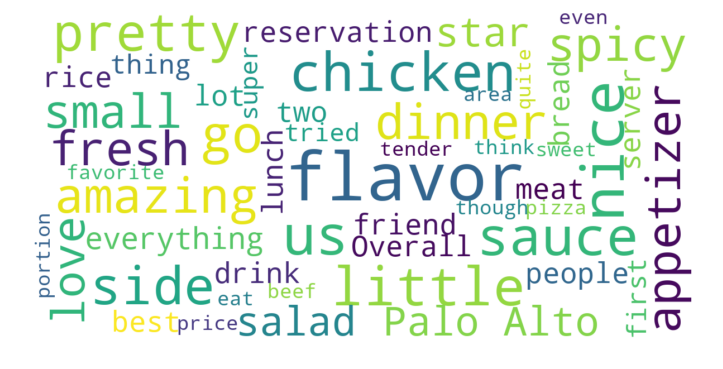

In [35]:
wordcloud_city(place='Palo Alto, CA',num_restaurant=25)


 Top restaurants found
----------------------------------------------------------------------------------------------------
The Purple Pig, Girl & the Goat, Fusion 58, Au Cheval, It’s Greek 2 U Grill, Little Bad Wolf, Crisp, Bar Biscay, Moccozy, Quartino Ristorante, Min’s Noodle House, Little Goat Diner, Knife & Tine, WJ Noodles, Mother Cluckers Kitchen, Summer House Santa Monica, SafeHouse Chicago, Bar Biscay, Smoque BBQ, Edgewater Tacos, Min’s Noodle House, Mable’s Table, Summer House Santa Monica, Knife & Tine, SafeHouse Chicago, 

Gathering top reviews on The Purple Pig now...
Reviews for The Purple Pig gathered.
------------------------------------------------------------
Gathering top reviews on Girl & the Goat now...
Reviews for Girl & the Goat gathered.
------------------------------------------------------------
Gathering top reviews on Fusion 58 now...
Reviews for Fusion 58 gathered.
------------------------------------------------------------
Gathering top reviews on Au Che

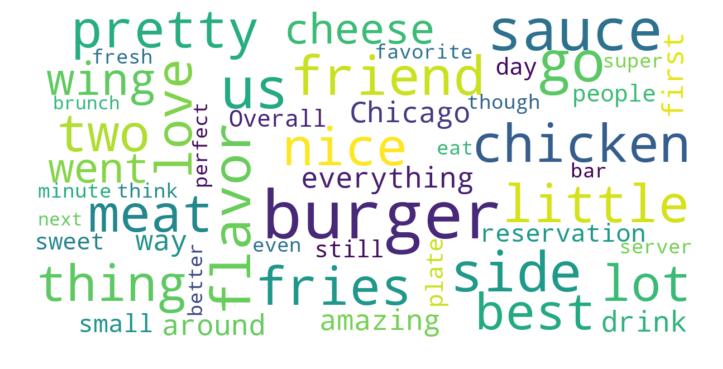

In [40]:
wordcloud_city(place='Chicago',num_restaurant=25)

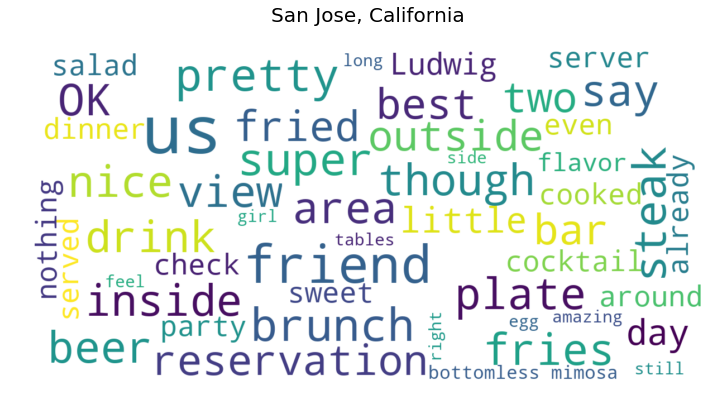

In [75]:
wc=wordcloud_city(place='San Jose, California',num_restaurant=5,num_reviews=5,verbosity=0)

## Top 20 US cities food scene word cloud

In [59]:
cities=pd.read_html("http://www.citymayors.com/gratis/uscities_100.html")

In [64]:
cities_list=list(cities[1][1])

In [66]:
cities_list.pop(0)

'City; State'

In [69]:
Top_cities=[x.split(';')[0] for x in cities_list[:20]]

In [70]:
Top_cities

['New York City',
 'Los Angeles',
 'Chicago',
 'Houston',
 'Philadelphia',
 'Phoenix',
 'San Antonio',
 'San Diego',
 'Dallas',
 'San Jose',
 'Austin',
 'Jacksonville',
 'Indianapolis',
 'San Francisco',
 'Columbus',
 'Fort Worth',
 'Charlotte',
 'Detroit',
 'El Paso',
 'Memphis']

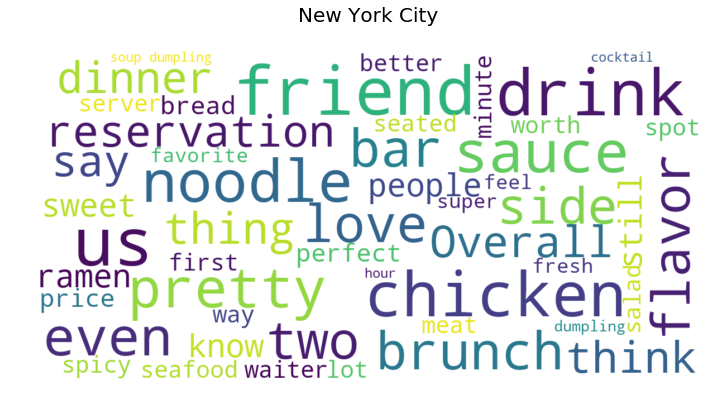

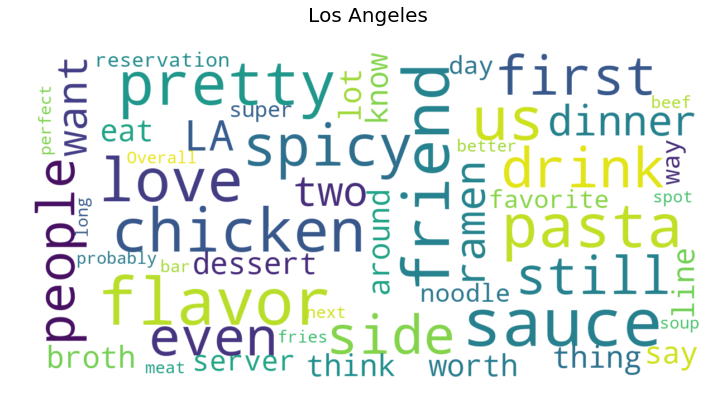

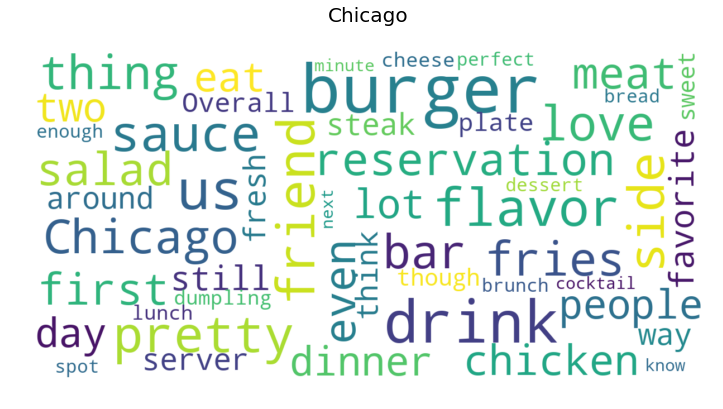

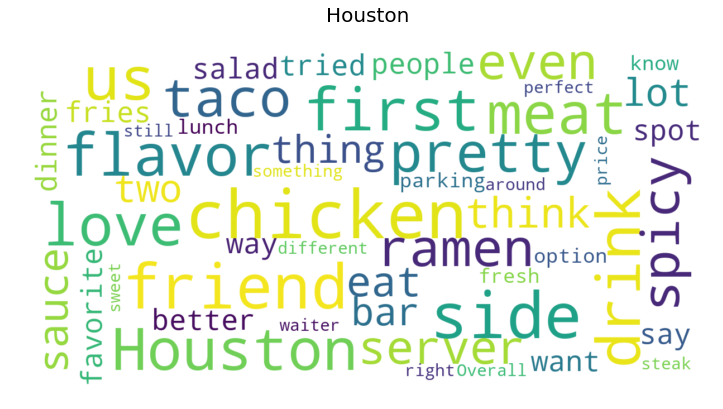

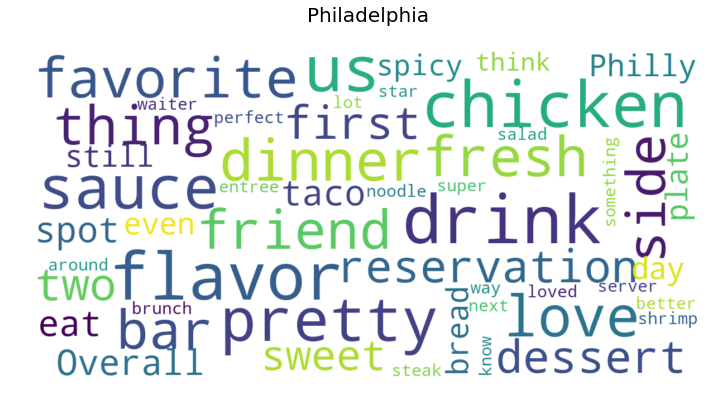

In [83]:
for city in Top_cities[:5]:
    wordcloud_city(city,verbosity=0,num_restaurant=100)